/tmp/ipykernel_3933538/1338542902.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_checkpoint = torch.load('./outputs/models/best_student_model.pth', map_location=

Sparsity sau khi áp dụng pruning: 30.01%
0.95
Fine-tuning hoàn tất.


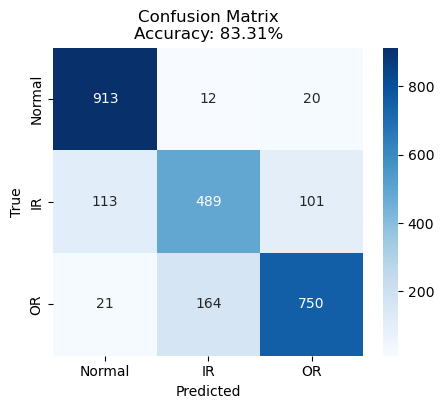

 - Model accuracy: 83.31%


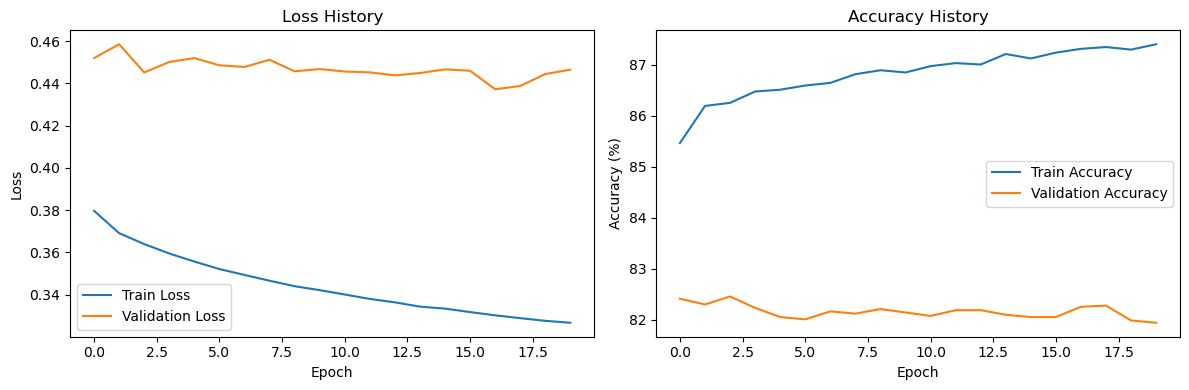

In [1]:
import cfg
from src import data_loader as data_loader, models, trainer, evaluate
from torchinfo import summary
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch
import torch.nn.utils.prune as prune

accuracy_list = []

model = models.Narrow_1DCNN(1,3)
model_checkpoint = torch.load('./outputs/models/best_student_model.pth', map_location=cfg.DEVICE)
model.load_state_dict(model_checkpoint['model_state_dict']) #what this
model.eval()

def get_sparsity(model):
    total_zeros = 0
    total_params = 0
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv1d, nn.Linear)):
            total_zeros += torch.sum(module.weight == 0)
            total_params += module.weight.nelement()
    return 100. * float(total_zeros) / float(total_params)

modules_to_prune = []
for name, module in model.named_modules():
    if isinstance(module, (nn.Conv1d, nn.Linear)):
        modules_to_prune.append((module, 'weight')) # Prune tham số 'weight'

# Chọn chiến lược: L1 Unstructured Pruning
# Tỉa 30% các trọng số có giá trị L1-norm nhỏ nhất trên toàn cục
prune.global_unstructured(
    modules_to_prune,
    pruning_method=prune.L1Unstructured,
    amount=0.3,  # Tỉ lệ tỉa 30%
)

print(f"Sparsity sau khi áp dụng pruning: {get_sparsity(model):.2f}%")

X_train, Y_train, X_val, Y_val, X_test, Y_test, test_files, len_processed = data_loader.data_import(cfg, 500)
X_train = X_train *1e2
X_val = X_val *1e2
X_test = X_test *1e2
train_loader, val_loader, test_loader = data_loader.create_dataloaders(X_train, Y_train, X_val, Y_val,X_test, Y_test, cfg, len_processed)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= cfg.LEARNING_RATE) 
model, history = trainer.train_model(
    model, train_loader, val_loader, criterion, optimizer, 
    'best_student_pruned_finetuned.pth', # Tên file checkpoint mới
    scheduler=None, # Không cần scheduler phức tạp hoặc dùng LR cố định
    num_epochs=20, 
    device=cfg.DEVICE
)
print("Fine-tuning hoàn tất.")

accuracy = evaluate.plot_confusion_matrix(model, test_loader, 'cpu', cfg.CLASS_NAMES)
accuracy_list.append(accuracy)
evaluate.plot_history(history)

for module, param_name in modules_to_prune:
    prune.remove(module, param_name)

torch.save(model.state_dict(), './outputs/models/student_pruned_final.pth')


In [2]:
model.eval()
model.cpu() # Chuyển về CPU trước khi export

# --- Export sang ONNX ---
onnx_file_path = "./outputs/models/student_pruned.onnx"
dummy_input = torch.randn(1, 1, 86) # Batch size = 1

torch.onnx.export(
    model,
    dummy_input,
    onnx_file_path,
    export_params=True,
    opset_version=11, # Hoặc 12, 13. TensorRT thường hỗ trợ tốt các version này
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'}, # Cho phép batch size thay đổi
        'output': {0: 'batch_size'}
    }
)